 <h1 align="center">Final_Project_Brain_Tumor_Classifier</h1>

 <h3 align="center">Authors: Noa Mansbach & Ido Shapira</h3>   

#### Project Overview and Objective:
- The main purpose of this project was to build models that would classify if a subject has a tumor or not based on an MRI scan. The model would try to learn the pattern of Brain Tumor in the MRI scans with different conditions such as - brain shape, size of the tumor etc.
- In addition, we would like to test whether we can, after training a model, develop an application that, given an image, will be able to classify whether a person has a brain tumor or not, so that it will be open for use by each doctor.

#### Data-Set Description:
The image data that was used for this problem is Brain MRI Images for Brain Tumor Detection from Kaggle web. It consists 253 MRI scans of two classes:
* NO - no tumor, encoded as 0 - 98 images
* YES - tumor, encoded as 1 - 155 images

#### Our Techniques: 
We will build a number of models based on different learning techniques some of which we learned in the course during the semester.
1. KNN model - finding a K-nearby neighbor.
2. SVM model - Support Vector Machine
3. Random Forest model - a forest of decision trees.
4. CNN model - a technique we learned in the "deep learning" course that we think will give good results on the database.

#### The difficulties and solutions:
1. There was a black frame around the brain area in the images, and we wanted to remove it in order to optimize the model's training. 
Therefore  we wrote a sophisticated algorithm that finds the edges of the brain area in the image and crops according to it. But then we got that each image has a different size. Eventually we decided to use the resize algorithm to remove the black areas by naive way.
2. In our data there were images of different sizes, some in RGB and some in grayscale. To maintain uniformity we converted all the images to be grayscale and 64 * 64 in size.
3. The data has an imbalance in the amount of images that contain a tumor and those that do not. There are 155 that contain a tumor and 98 that do not. We saw that this imbalance affects the results of the CNN model. Therefore we solved this by giving a factor of 1.5 to the error weight of the images without the magnification
4. We had an overfitting in the CNN model. In order to overcome this we made the model less complex and limited the amount of iterations, also we add dropout of 30%.


## Code:

### Import all the necessary libraries:
We have used Python libraries:
- sklearn
- tensorflow

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random as rn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import display, Image

import matplotlib.pyplot as plt
import seaborn as sns

## fix random seed:

In [2]:
rs = 42 # random seed
np.random.seed(rs)
rn.seed(rs)

# Import the data:

In [3]:
X = []
Z = []
IMG_SIZE=64

NO_DIR='./data/brain_tumor_dataset/no'
YES_DIR='./data/brain_tumor_dataset/yes'

We face up with dataset that contains both RGB and gray scale images, therefore we decided to convert all images to be gray scale.

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img=np.asarray(img)
        X.append(np_img)
        Z.append(str(label))

In [5]:
# make 'No' data
make_train_data('No',NO_DIR)
print(len(X))

100%|██████████| 98/98 [00:00<00:00, 967.65it/s]

98


In [6]:
# make 'Yes' data
make_train_data('Yes',YES_DIR)
print(len(X))

100%|██████████| 155/155 [00:00<00:00, 828.23it/s]

253


Description of the data:
1. Number of instances: 253
2. Number of attributes: 64*64

## Check some image

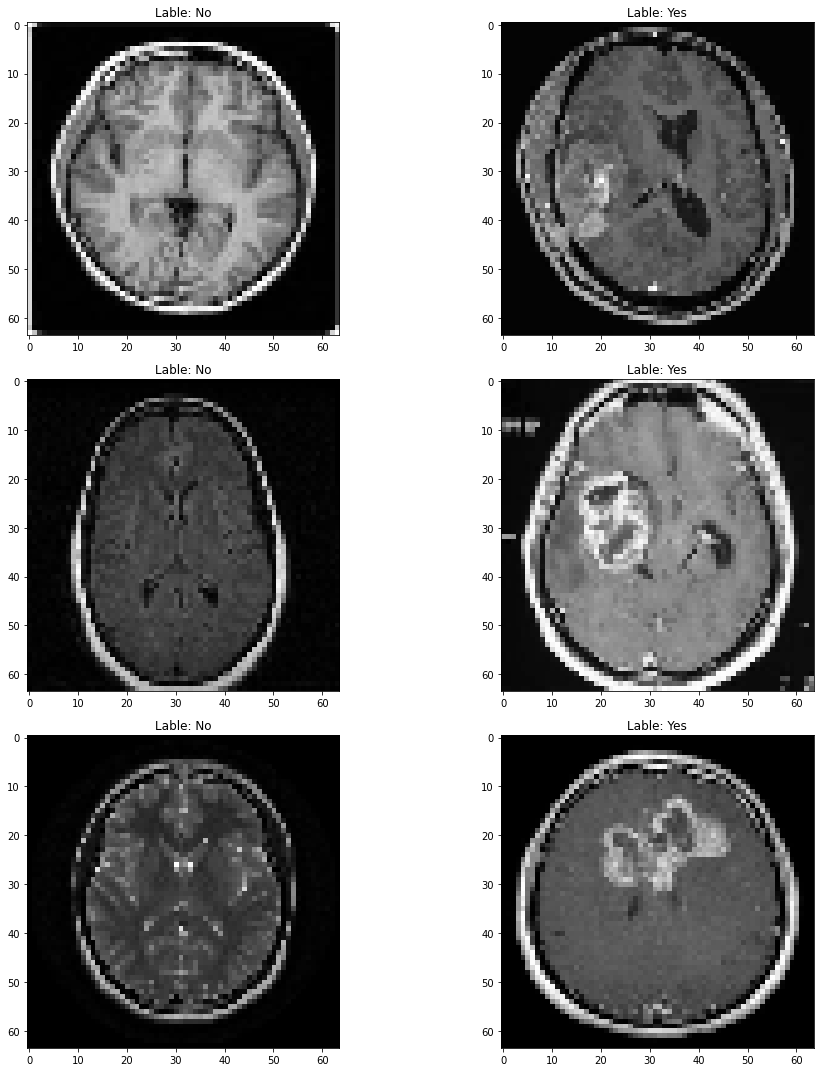

In [7]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):      
#         l=rn.randint(0,len(Z))
#         ax[i,j].imshow(X[l], cmap='gray')
#         ax[i,j].set_title('Lable: '+Z[l])
        if j == 0:
            ax[i,j].imshow(X[i], cmap='gray')
            ax[i,j].set_title('Lable: '+Z[i])
        else:
            ax[i,j].imshow(X[len(Z) - 1 - i], cmap='gray')
            ax[i,j].set_title('Lable: '+Z[len(Z) -1 - i])
        
plt.tight_layout()

We note that some of the images have large black areas arrond the brain scan, thus we decided to crop the image such that only the brain scan would remain.

In [8]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    i=0
    for img in set_name:
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

                # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # add contour on the image
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         if new_img.shape[0] > IMG_SIZE:
#             print('img: ', img.shape)
#             print('new_img: ', new_img.shape)
        new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE) , interpolation=cv2.INTER_CUBIC)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        set_new.append(np.asarray(new_img))
        
        if i % 25 == 0:
            plt.figure(figsize=(15,6))
            plt.subplot(141)
            plt.imshow(img,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 1. Get the original image')
            plt.subplot(142)
            plt.imshow(img_cnt,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 2. Find the biggest contour')
            plt.subplot(143)
            plt.imshow(img_pnt,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 3. Find the extreme points')
            plt.subplot(144)
            plt.imshow(new_img,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 4. Crop and resize the image')
        
        i= i+1
        plt.show()
    return set_new

In [9]:
# X_crop=crop_imgs(X)

### Label encoding:

'No' = 0

'Yes' = 1

In [10]:
Y = np.array(Z)
Y = np.where(Y=='No', 0, Y)
Y = np.where(Y=='Yes', 1, Y)
Y = Y.astype('int32')

### Normalization and flatten the images:

In [11]:
X = np.array([cv2.normalize(X[i], None, 0, 255, cv2.NORM_MINMAX) for i in range(len(X))]) # normalization
X=np.array(X)/255
# X = X.flatten().reshape(len(X), (IMG_SIZE ** 2) * 3) # 3 is because it is RGB image 
X = X.flatten().reshape(len(X), (IMG_SIZE ** 2))

### Our dataset:

In [12]:
df = pd.DataFrame(data=X)
df

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.000000,0.815686,0.156863,0.074510,0.058824,0.047059,0.047059,0.047059,0.050980,0.050980,...,0.047059,0.047059,0.047059,0.047059,0.050980,0.058824,0.035294,0.215686,0.823529,0.996078
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015686,0.003922,0.011765,0.007843,0.011765,0.007843,0.023529,0.003922,0.007843
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
4,0.274510,0.023529,0.015686,0.003922,0.023529,0.019608,0.015686,0.003922,0.011765,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922
249,0.007843,0.007843,0.007843,0.007843,0.007843,0.015686,0.007843,0.007843,0.007843,0.007843,...,0.015686,0.015686,0.015686,0.007843,0.007843,0.007843,0.019608,0.007843,0.007843,0.007843
250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
251,0.031373,0.027451,0.023529,0.011765,0.027451,0.027451,0.027451,0.031373,0.031373,0.027451,...,0.043137,0.043137,0.043137,0.313725,0.066667,0.039216,0.047059,0.058824,0.666667,0.349020


### Train-Test Split:

In [13]:
# separate data
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=rs, shuffle=True)

freqs = pd.DataFrame({"Training dataset": [(y_train == 1).sum(),(y_train == 0).sum()],
                      "Test dataset": [(y_test == 1).sum(),(y_test == 0).sum()],
                      "Total": [(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 0).sum()+(y_test == 0).sum()]},
                     index=["Yes", "No"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
Yes,124,31,155
No,78,20,98


In [14]:
def statistics(confusion):
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print('True Positives (TP):',TP)
    print('True Negatives (TN):',TN)
    print('False Positives (FP):',FP)
    print('False Negarives (FN):',FN)
    print('Classification Accuracy:',(TP + TN) / float(TP + TN + FP + FN))
    precision = TN / float(TN + FP)
    print('Precision:',precision)
    recall = TP / float(TP + FN)
    print('Recall:', recall)
    print('f-score:', 2 * precision * recall / (precision + recall))

In [15]:
def cm_analysis(y_true, y_pred, labels, figsize=(7,6)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_result = pd.DataFrame(cm, index=labels, columns=labels)
    cm_result.index.name = 'Actual'
    cm_result.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Blues')
    #plt.savefig(filename)
    plt.show()
    return cm_result, cm

# Using Support Vector Machine (SVM)

In [16]:
# Create a svm classifier:
param_grid = [
  {'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear', 'sigmoid']},
 ]
svc = SVC()
svc_classifier = GridSearchCV(svc, param_grid, verbose = 1)
svc_classifier.fit(X_train, y_train)
#fit to the training data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100],
                          'kernel': ['rbf', 'linear', 'sigmoid']}],
             verbose=1)

### the best parameters for the model:

In [17]:
print(svc_classifier.best_score_)
print(svc_classifier.best_params_)

0.8271951219512195
{'C': 10, 'kernel': 'rbf'}


### Prediction:

In [18]:
y_pred = svc_classifier.predict(X_test)

### Confusion matrix and result report:

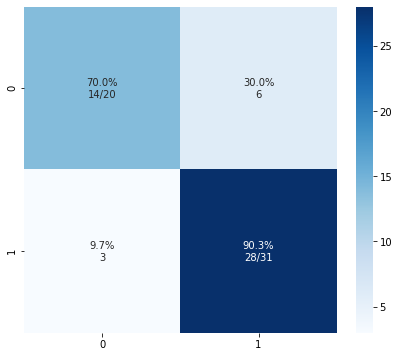

In [19]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [20]:
statistics(cm)

True Positives (TP): 28
True Negatives (TN): 14
False Positives (FP): 6
False Negarives (FN): 3
Classification Accuracy: 0.8235294117647058
Precision: 0.7
Recall: 0.9032258064516129
f-score: 0.7887323943661972


# Using k-nearest neighbors (KNN)

In [21]:
# Create a knn classifier:
param_grid = [
  {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']},
 ]
knn = KNeighborsClassifier()
knn_classifier = GridSearchCV(knn, param_grid, verbose = 1)
knn_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

### the best parameters for the model:

In [22]:
print(knn_classifier.best_score_)
print(knn_classifier.best_params_)

0.8021951219512194
{'n_neighbors': 14, 'weights': 'distance'}


### Prediction:

In [23]:
y_pred = knn_classifier.predict(X_test)

### Confusion matrix and result report:

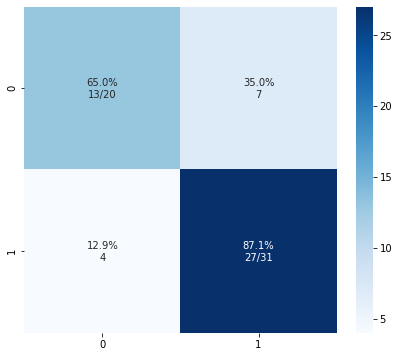

In [24]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [25]:
statistics(cm)

True Positives (TP): 27
True Negatives (TN): 13
False Positives (FP): 7
False Negarives (FN): 4
Classification Accuracy: 0.7843137254901961
Precision: 0.65
Recall: 0.8709677419354839
f-score: 0.7444326617179216


# Using Random Forest model

In [26]:
# Create a Random Forest classifier:
param_grid = { 
    'n_estimators': [10,50,100,200,500],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier()
rfc_classifier = GridSearchCV(rfc, param_grid, verbose = 1)
rfc_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200, 500]},
             verbose=1)

### the best parameters for the model:

In [27]:
print(rfc_classifier.best_score_)
print(rfc_classifier.best_params_)

0.8373170731707317
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}


### Prediction:

In [28]:
y_pred = rfc_classifier.predict(X_test)

### Confusion matrix and result report:

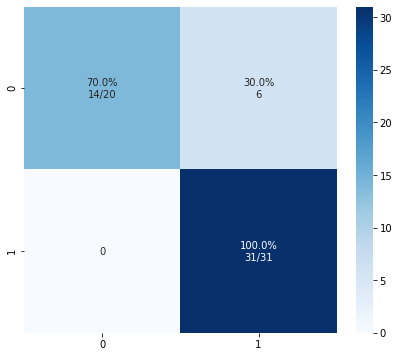

In [29]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [30]:
statistics(cm)

True Positives (TP): 31
True Negatives (TN): 14
False Positives (FP): 6
False Negarives (FN): 0
Classification Accuracy: 0.8823529411764706
Precision: 0.7
Recall: 1.0
f-score: 0.8235294117647058


# Using Deep Learning method - CNN

## Part 1 - Data Preprocessing

## Split into train , test data

In [31]:
# train, test split
splitfolders.ratio('./data/brain_tumor_dataset/', output="./data/brain_tumor_dataset_split", ratio=(0.7, 0.3))

Copying files: 253 files [00:00, 12398.31 files/s]


### Preprocessing the Training set

In [32]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train = train_datagen.flow_from_directory('./data/brain_tumor_dataset_split/train',
                                                 target_size = (IMG_SIZE,IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True, seed=rs )

Found 183 images belonging to 2 classes.


In [33]:
train.class_indices

{'no': 0, 'yes': 1}

In [34]:
yes=np.count_nonzero(train.classes)
print("Yes:",yes)
print("No:",176-yes)

Yes: 108
No: 68


### Preprocessing the Test set

In [35]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test = test_datagen.flow_from_directory('data/brain_tumor_dataset_split/val/',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True, seed=rs )

Found 84 images belonging to 2 classes.


In [36]:
yes_test=np.count_nonzero(test.classes)
print("Yes:",yes_test)
print("No:",77-yes_test)

Yes: 47
No: 30


In [37]:
len(test.classes)

84

## Part 2 - Building the CNN

In [38]:
### Init the CNN model
cnn = tf.keras.models.Sequential()

### Convolution and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=[IMG_SIZE,IMG_SIZE,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a third convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a fourth convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Flattening
cnn.add(tf.keras.layers.Flatten())

### Fully Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Dropout
cnn.add(tf.keras.layers.Dropout(0.3))

### Output Layer
# cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the CNN

### Compiling the CNN

In [39]:
def weighted_loss(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits( labels, logits, weight)
        return loss
    return weighted_cross_entropy_with_logits

cnn.compile(optimizer = 'adam', loss = weighted_loss(weight=1.5), metrics = ['accuracy'])
# cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### Summary of the model

In [40]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          4

### Training the CNN on the Training set and evaluating it on the Test set

In [41]:
history=cnn.fit(x = train, epochs = 150 ,validation_data=test)

Epoch 1/150
6/6 [==============================] - 2s 102ms/step - loss: 0.8250 - accuracy: 0.4812 - val_loss: 0.8260 - val_accuracy: 0.5595
Epoch 2/150
6/6 [==============================] - 0s 54ms/step - loss: 0.8131 - accuracy: 0.5830 - val_loss: 0.8179 - val_accuracy: 0.5595
Epoch 3/150
6/6 [==============================] - 0s 54ms/step - loss: 0.8049 - accuracy: 0.5881 - val_loss: 0.8217 - val_accuracy: 0.5595
Epoch 4/150
6/6 [==============================] - 0s 57ms/step - loss: 0.8135 - accuracy: 0.5713 - val_loss: 0.8173 - val_accuracy: 0.5595
Epoch 5/150
6/6 [==============================] - 0s 53ms/step - loss: 0.7943 - accuracy: 0.5987 - val_loss: 0.8138 - val_accuracy: 0.5595
Epoch 6/150
6/6 [==============================] - 0s 55ms/step - loss: 0.8109 - accuracy: 0.5649 - val_loss: 0.8143 - val_accuracy: 0.5595
Epoch 7/150
6/6 [==============================] - 0s 55ms/step - loss: 0.7991 - accuracy: 0.5795 - val_loss: 0.8103 - val_accuracy: 0.5595
Epoch 8/150
6/6 [==

6/6 [==============================] - 0s 55ms/step - loss: 0.6751 - accuracy: 0.8029 - val_loss: 0.6808 - val_accuracy: 0.8214
Epoch 60/150
6/6 [==============================] - 0s 55ms/step - loss: 0.6450 - accuracy: 0.8555 - val_loss: 0.6608 - val_accuracy: 0.8690
Epoch 61/150
6/6 [==============================] - 0s 55ms/step - loss: 0.6481 - accuracy: 0.8297 - val_loss: 0.6814 - val_accuracy: 0.8214
Epoch 62/150
6/6 [==============================] - 0s 55ms/step - loss: 0.6730 - accuracy: 0.8377 - val_loss: 0.6565 - val_accuracy: 0.8690
Epoch 63/150
6/6 [==============================] - 0s 54ms/step - loss: 0.6609 - accuracy: 0.8411 - val_loss: 0.6580 - val_accuracy: 0.8571
Epoch 64/150
6/6 [==============================] - 0s 54ms/step - loss: 0.6414 - accuracy: 0.8772 - val_loss: 0.6569 - val_accuracy: 0.8690
Epoch 65/150
6/6 [==============================] - 0s 55ms/step - loss: 0.6502 - accuracy: 0.8768 - val_loss: 0.6528 - val_accuracy: 0.8690
Epoch 66/150
6/6 [========

6/6 [==============================] - 0s 54ms/step - loss: 0.5984 - accuracy: 0.9281 - val_loss: 0.6353 - val_accuracy: 0.8810
Epoch 118/150
6/6 [==============================] - 0s 54ms/step - loss: 0.6075 - accuracy: 0.9381 - val_loss: 0.6311 - val_accuracy: 0.9048
Epoch 119/150
6/6 [==============================] - 0s 53ms/step - loss: 0.5930 - accuracy: 0.9506 - val_loss: 0.6559 - val_accuracy: 0.8571
Epoch 120/150
6/6 [==============================] - 0s 53ms/step - loss: 0.6018 - accuracy: 0.9365 - val_loss: 0.6608 - val_accuracy: 0.8333
Epoch 121/150
6/6 [==============================] - 0s 53ms/step - loss: 0.6290 - accuracy: 0.9241 - val_loss: 0.6548 - val_accuracy: 0.8571
Epoch 122/150
6/6 [==============================] - 0s 53ms/step - loss: 0.6034 - accuracy: 0.9262 - val_loss: 0.6405 - val_accuracy: 0.8810
Epoch 123/150
6/6 [==============================] - 0s 53ms/step - loss: 0.5855 - accuracy: 0.9494 - val_loss: 0.6407 - val_accuracy: 0.8810
Epoch 124/150
6/6 [=

### Train accuracy

In [42]:
cnn.evaluate(train)

6/6 [==============================] - 0s 36ms/step - loss: 0.5934 - accuracy: 0.9508


[0.5934363007545471, 0.9508196711540222]

### Test accuracy 

In [43]:
cnn.evaluate(test)

3/3 [==============================] - 0s 18ms/step - loss: 0.6269 - accuracy: 0.9048


[0.6268501877784729, 0.9047619104385376]

In [44]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()
    #plt.show()
    
    # Accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

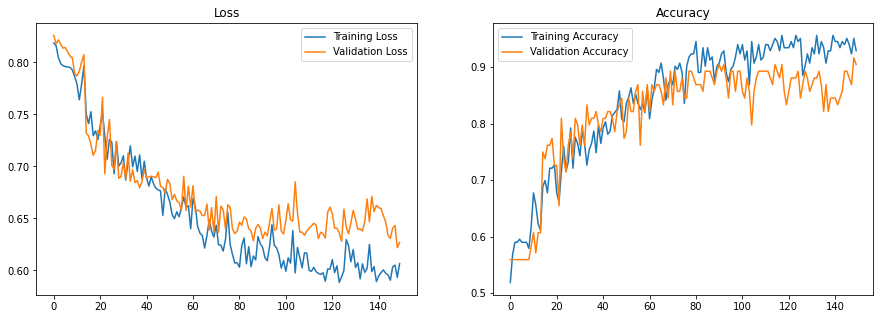

In [45]:
plot_metrics(history)

In [46]:
# Y_pred = cnn.predict(test)
# y_pred = np.argmax(Y_pred, axis=1)

# print('Confusion Matrix')
# print(confusion_matrix(test.classes, y_pred))

## Part 4 - Making single predictions

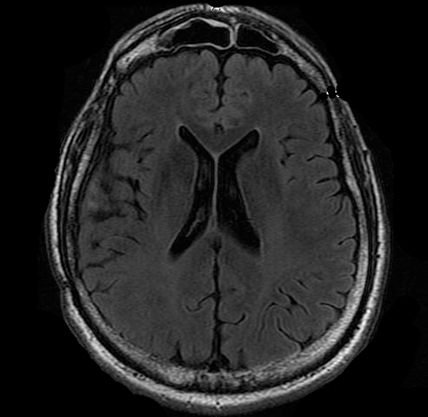

Actual: No
Predicted: No


In [47]:
display(Image(filename='./data/brain_tumor_dataset_split/val/no/7 no.jpg'))
test_image = image.load_img('./data/brain_tumor_dataset_split/val/no/46 no.jpg', target_size = (IMG_SIZE, IMG_SIZE))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
if result[0][0] == 1:
    prediction = 'Yes'
else:
    prediction = 'No'

print("Actual: No")
print("Predicted:", prediction)

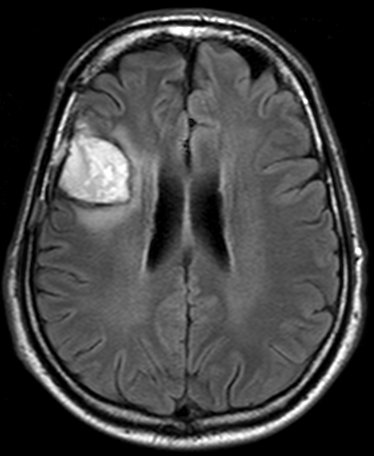

Actual: Yes
Predicted: Yes


In [48]:
display(Image(filename='./data/brain_tumor_dataset_split/val/yes/Y7.jpg'))
test_image = image.load_img('./data/brain_tumor_dataset_split/val/yes/Y7.jpg', target_size = (IMG_SIZE, IMG_SIZE))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train.class_indices
if result[0][0] == 1:
    prediction = 'Yes'
else:
    prediction = 'No'

print("Actual: Yes")
print("Predicted:", prediction)